In [131]:
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split

data = pd.read_csv('./data_v4.csv')

c1 = 0
c2 = 0
c3 = 0
for i in range(420):
    #print(i)
    data.loc[i, 'bug_num'] = data.loc[i, 'bug_num'] * 1.0 / data.loc[i, 'LOC']
    if data.loc[i, 'bug_num'] >= 0.01:
        c1 += 1
    elif data.loc[i, 'bug_num'] >= 0.001:
        c2 += 1
    else:
        c3 += 1
print(c1)       
print(c2) 
print(c3) 

def foo(x):
    if x >= 0.01:
        return 2
    if x >= 0.001:
        return 1
    return 0

data['bug_num'] = data['bug_num'].map(lambda x: foo(x))



130
197
93


In [132]:
'''
created_at,
updated_at,
size, #
stargazers_count,
watchers_count, #
forks_count, #
network_count, #
subscribers_count, #
followers, #
public_repos, #
created_at,
contributions, #
author_id,
LOC, #
Add, #
Delete, #
Files, #
bug_num  #
'''

feature_columns = [
    'size',
    'watchers_count',
    'forks_count',
    'network_count',
    'subscribers_count',
    
    'followers',
    'public_repos',
    'contributions',
    #'LOC',
    #'Add',
    #'Delete',
    #'Files',
]

target_column = 'bug_num'

train, test = train_test_split(data, test_size=0.2, random_state=1)
xgtrain = xgb.DMatrix(train[feature_columns].values, train[target_column].values)
xgtest = xgb.DMatrix(test[feature_columns].values, test[target_column].values)

print("the train size is {}".format(len(train[target_column].values)))
print("the test size is {}".format(len(test[target_column].values)))

params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'num_class': 3,
    'gamma': 0.1,
    'max_depth': 6,
    'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 2,
    'silent': 1,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
}

# build the model
num_round = 500
bst = xgb.train(params, xgtrain, num_round)

# prediction and check the accuracy
preds = bst.predict(xgtest)
labels = xgtest.get_label()

match = 0.0
for i in range(len(preds)):
    if preds[i] == labels[i]:
        match += 1
acc = match / len(preds) * 100.0

print("accuracy rate is {}".format(acc))


the train size is 336
the test size is 84
[01:14:43] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:14:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy rate is 48.80952380952381


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

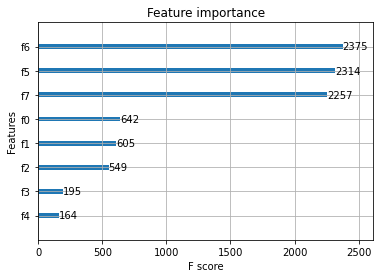

In [133]:
# data analysis
plot_importance(bst, importance_type ='weight')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

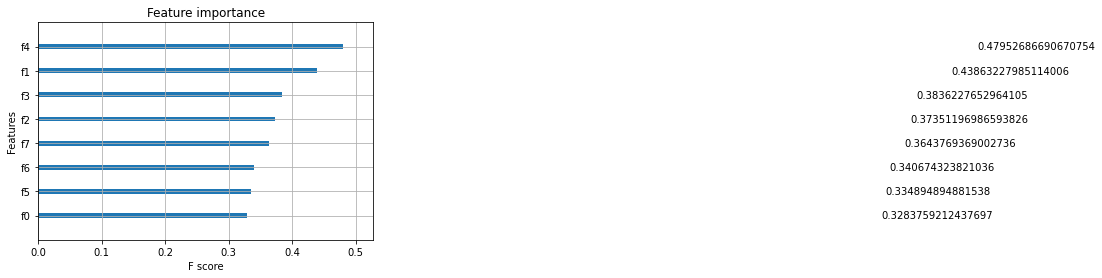

In [134]:
plot_importance(bst, importance_type ='gain')